In [1]:
import os

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
import statsmodels.tsa.api as smt
import fbprophet

from  sklearn import metrics 

import tqdm

plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_theme()

Importing plotly failed. Interactive plots will not work.


In [2]:
from sklearn.model_selection import TimeSeriesSplit

In [3]:
data_path = "../downloads/demand-forecasting-kernels-only/train.csv"
df = pd.read_csv(data_path)

In [4]:
df.date = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['weeknum'] = df.date.dt.weekofyear

In [175]:
first_item = df.query('item == 1')

In [176]:
first_item_first_store = first_item.query('store==1')

In [385]:
first_item_first_store.dropna().head()

,date,store,item,sales,year,month,weeknum,sales_rolling_7
6,2013-01-07,1,1,10,2013,1,2,11.857143
7,2013-01-08,1,1,9,2013,1,2,11.285714
8,2013-01-09,1,1,12,2013,1,2,11.428571
9,2013-01-10,1,1,9,2013,1,2,10.714286
10,2013-01-11,1,1,9,2013,1,2,10.142857


In [179]:
splitter = TimeSeriesSplit(n_splits=3, max_train_size=720)

In [394]:
def fbprophet_predict(data : pd.DataFrame, prediction_part: int, display_interval=365, train_days=None):
    if train_days is not None:
        train = data.iloc[-train_days-prediction_part:-prediction_part]
    else:
        train = data.iloc[:-prediction_part]
        
        
    model = fbprophet.Prophet(yearly_seasonality=True)
    pred = model.fit(train)
    yhat = pred.predict(data.iloc[-prediction_part:])
    test = data.iloc[-prediction_part:]
    
    #print(train.iloc[-1], test.iloc[0])

    fig, ax = plt.subplots(figsize=(15,8))
    train_display = display_interval

    mse = metrics.mean_squared_error(test.y.values, yhat.yhat.values)
    ax.set_title(f'MSE {mse}')

    sns.lineplot(x='ds', y='y' , data = train.iloc[-train_display:], ax= ax)
    sns.lineplot(x='ds', y='y' , data = test, ax= ax, color='green')
    sns.lineplot(x='ds', y='yhat' , data = yhat, ax=ax, color='red')
    return yhat.yhat.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds    2017-12-01 00:00:00
y                      19
Name: 1795, dtype: object ds    2017-12-02 00:00:00
y                      16
Name: 1796, dtype: object


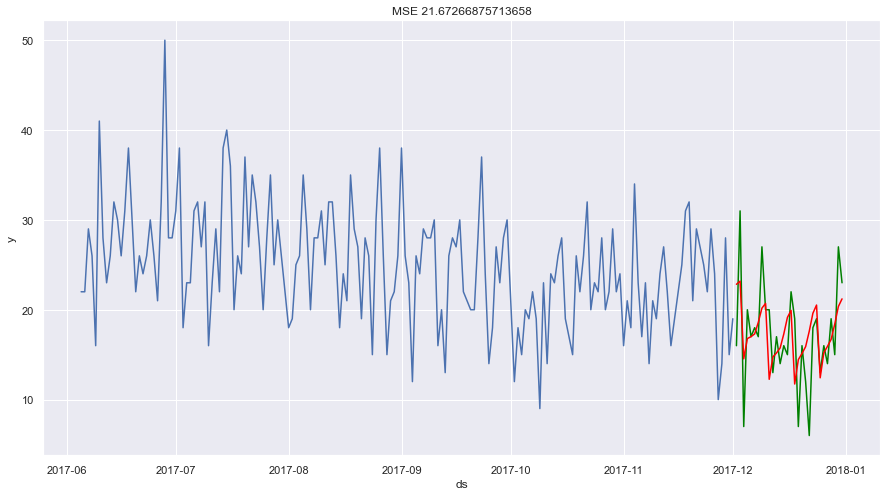

In [393]:
data = first_item_first_store[['date', 'sales']].rename(columns={'date':'ds', 'sales':'y'})
fbprophet_predictions = fbprophet_predict(data, prediction_part = 30, display_interval=180)

In [399]:
first_item_first_store['sales_rolling_7'] = first_item_first_store.sales.rolling(7).mean()
first_item_first_store['sales_rolling_14'] = first_item_first_store.sales.rolling(14).mean()

/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


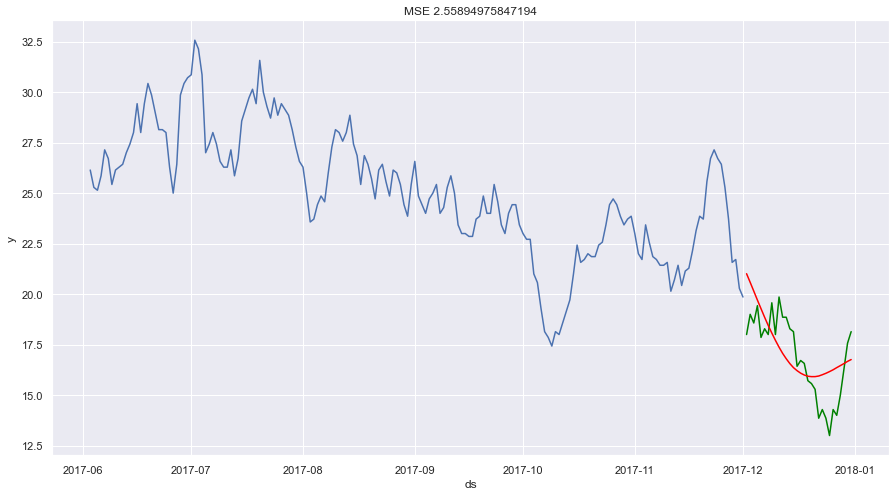

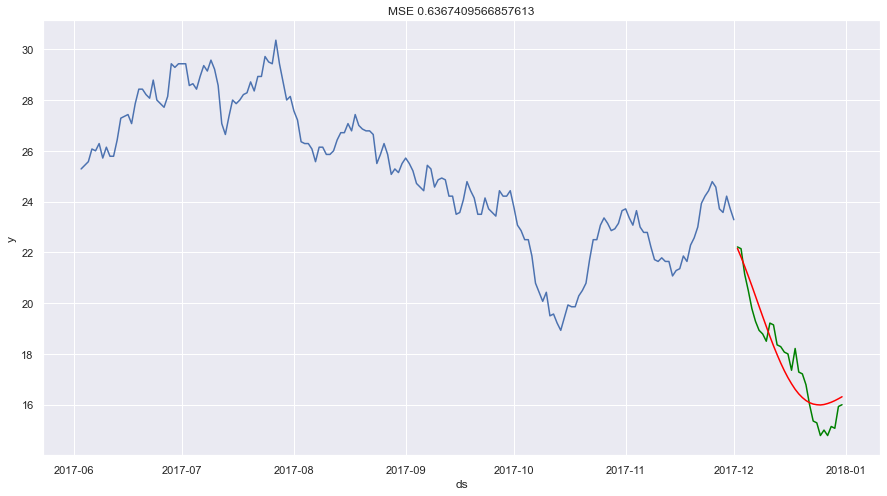

In [401]:
data_rolling_7 = first_item_first_store[['date', 'sales_rolling_7']].rename(columns={'date':'ds', 'sales_rolling_7':'y'})
data_rolling_7 = data_rolling_7.dropna()
fbprophet_predict_7 =  fbprophet_predict(data_rolling_7, prediction_part= 30, display_interval=182)

data_rolling_14 = first_item_first_store[['date', 'sales_rolling_14']].rename(columns={'date':'ds', 'sales_rolling_14':'y'})
data_rolling_14 = data_rolling_14.dropna()
fbprophet_predict_14 =  fbprophet_predict(data_rolling_14, prediction_part= 30, display_interval=182)


## XGBOOST + auto xgboost?

In [ ]:
Когда мы делаем несколько предсказаний вперед, то мы t+1 делаем на основе 1:t-1 или на основе 1:t? 
Или сделать модель которая выдает сразу несколько (это возможно несколько целевых переменных иметь?)
    
Если есть тренд, то лучше от него избавиться или добавить про него информацию в модель? Или после модели?


A nice method for having lower forecasting errors with LSTM is using STL decomposition. This way you can decompose the time series in trend, seasonal and residual and by performing forecast on each of those components and summing your results you can make your predictions much more robust.

In [48]:
first_item_first_store.tail()

,date,store,item,sales,year,month,weeknum,sales_rolling_7,sales_rolling_14
3647,2017-12-27,2,1,19,2017,12,52,22.428571,23.571429
3648,2017-12-28,2,1,21,2017,12,52,22.428571,23.785714
3649,2017-12-29,2,1,18,2017,12,52,21.000000,23.285714
3650,2017-12-30,2,1,24,2017,12,52,21.857143,22.857143
3651,2017-12-31,2,1,31,2017,12,52,22.285714,21.857143


## Scheme #1 
t0 t1 t2 t3 t4 t5 t6  predict t7

In [ ]:
We want to predict the last month

In [405]:
col = 'sales_rolling_14'
data = first_item_first_store[['date', col]].copy()
data.rename(columns={col: 'y'}, inplace=True)
data.set_index('date', inplace=True)
data.tail()

,y
date,
2017-12-27,14.785714
2017-12-28,15.142857
2017-12-29,15.071429
2017-12-30,15.928571
2017-12-31,16.000000


In [406]:
for lag in range(1,182):
    data[f'lag_{lag}'] = data.y.shift(lag)

In [407]:
data.dropna(inplace=True)
data.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181
date,,,,,,,,,,,,,,,,,,,,,
2013-07-14,21.785714,21.428571,21.285714,20.428571,20.500000,21.000000,20.857143,20.642857,19.928571,20.428571,...,9.928571,10.142857,10.285714,10.428571,10.214286,9.642857,10.071429,9.928571,10.214286,10.785714
2013-07-15,21.428571,21.785714,21.428571,21.285714,20.428571,20.500000,21.000000,20.857143,20.642857,19.928571,...,9.857143,9.928571,10.142857,10.285714,10.428571,10.214286,9.642857,10.071429,9.928571,10.214286
2013-07-16,21.071429,21.428571,21.785714,21.428571,21.285714,20.428571,20.500000,21.000000,20.857143,20.642857,...,10.214286,9.857143,9.928571,10.142857,10.285714,10.428571,10.214286,9.642857,10.071429,9.928571
2013-07-17,21.357143,21.071429,21.428571,21.785714,21.428571,21.285714,20.428571,20.500000,21.000000,20.857143,...,10.571429,10.214286,9.857143,9.928571,10.142857,10.285714,10.428571,10.214286,9.642857,10.071429
2013-07-18,21.142857,21.357143,21.071429,21.428571,21.785714,21.428571,21.285714,20.428571,20.500000,21.000000,...,10.714286,10.571429,10.214286,9.857143,9.928571,10.142857,10.285714,10.428571,10.214286,9.642857


we will use only the last two years

In [408]:
test_part = 30
train_start = -365*2
train_df = data.iloc[train_start:-test_part]
test_df = data.iloc[-test_part:]

In [409]:
test_df.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181
date,,,,,,,,,,,,,,,,,,,,,
2017-12-02,22.214286,23.285714,23.714286,24.214286,23.571429,23.714286,24.571429,24.785714,24.428571,24.214286,...,26.428571,25.785714,25.785714,26.142857,25.714286,26.285714,26.000000,26.071429,25.571429,25.428571
2017-12-03,22.142857,22.214286,23.285714,23.714286,24.214286,23.571429,23.714286,24.571429,24.785714,24.428571,...,27.285714,26.428571,25.785714,25.785714,26.142857,25.714286,26.285714,26.000000,26.071429,25.571429
2017-12-04,21.142857,22.142857,22.214286,23.285714,23.714286,24.214286,23.571429,23.714286,24.571429,24.785714,...,27.357143,27.285714,26.428571,25.785714,25.785714,26.142857,25.714286,26.285714,26.000000,26.071429
2017-12-05,20.500000,21.142857,22.142857,22.214286,23.285714,23.714286,24.214286,23.571429,23.714286,24.571429,...,27.428571,27.357143,27.285714,26.428571,25.785714,25.785714,26.142857,25.714286,26.285714,26.000000
2017-12-06,19.785714,20.500000,21.142857,22.142857,22.214286,23.285714,23.714286,24.214286,23.571429,23.714286,...,27.071429,27.428571,27.357143,27.285714,26.428571,25.785714,25.785714,26.142857,25.714286,26.285714


In [410]:
train_df.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181
date,,,,,,,,,,,,,,,,,,,,,
2017-11-27,23.714286,24.571429,24.785714,24.428571,24.214286,23.928571,23.000000,22.571429,22.285714,21.642857,...,26.285714,26.000000,26.071429,25.571429,25.428571,25.285714,25.142857,25.857143,26.071429,25.785714
2017-11-28,23.571429,23.714286,24.571429,24.785714,24.428571,24.214286,23.928571,23.000000,22.571429,22.285714,...,25.714286,26.285714,26.000000,26.071429,25.571429,25.428571,25.285714,25.142857,25.857143,26.071429
2017-11-29,24.214286,23.571429,23.714286,24.571429,24.785714,24.428571,24.214286,23.928571,23.000000,22.571429,...,26.142857,25.714286,26.285714,26.000000,26.071429,25.571429,25.428571,25.285714,25.142857,25.857143
2017-11-30,23.714286,24.214286,23.571429,23.714286,24.571429,24.785714,24.428571,24.214286,23.928571,23.000000,...,25.785714,26.142857,25.714286,26.285714,26.000000,26.071429,25.571429,25.428571,25.285714,25.142857
2017-12-01,23.285714,23.714286,24.214286,23.571429,23.714286,24.571429,24.785714,24.428571,24.214286,23.928571,...,25.785714,25.785714,26.142857,25.714286,26.285714,26.000000,26.071429,25.571429,25.428571,25.285714


In [411]:
import xgboost as xgb
from xgboost import XGBRegressor

In [412]:
xgbmodel = XGBRegressor(n_estimators=1000, verbosity=1, )

In [413]:
y_train = train_df[['y']]
X_train = train_df.drop(['y'], axis=1)

y_test = test_df[['y']]
X_test = test_df.drop(['y'], axis=1)

In [414]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [415]:
callbacks = [xgb.callback.EarlyStopping(rounds=10,
                                                save_best=True)]

xgbmodel.fit(X_train, y_train, eval_set=eval_set, verbose=10, callbacks=callbacks)

[0]	validation_0-rmse:15.48232	validation_1-rmse:12.12663
[10]	validation_0-rmse:0.57807	validation_1-rmse:0.67488
[20]	validation_0-rmse:0.20129	validation_1-rmse:0.56868
[23]	validation_0-rmse:0.18356	validation_1-rmse:0.57977


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

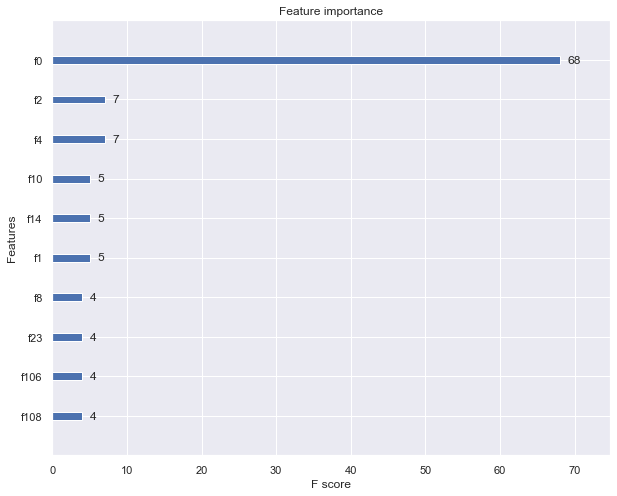

In [416]:
xgb.plot_importance(xgbmodel, max_num_features=10)

In [417]:
predictions = xgbmodel.predict(X_test)
predictions

array([22.591555, 22.134686, 22.21076 , 21.067547, 20.872658, 19.473833,
       18.785713, 18.51703 , 18.651537, 18.29213 , 18.911964, 18.926464,
       17.763802, 17.22605 , 17.614706, 17.614706, 16.894968, 17.489069,
       16.82299 , 16.82299 , 16.695126, 15.773838, 14.955665, 15.026035,
       14.766347, 14.840599, 14.854293, 15.43711 , 14.858174, 15.932155],
      dtype=float32)

In [418]:
y_test['xgb_pred'] = predictions

/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


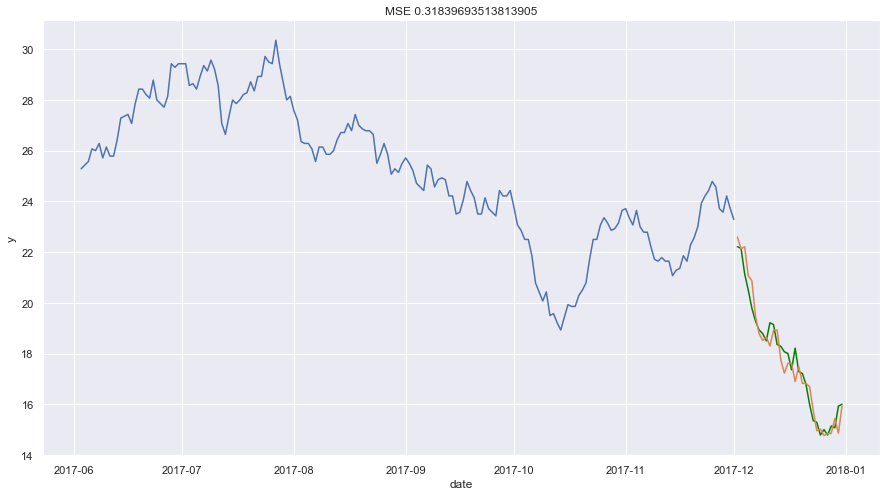

In [419]:
fig, ax = plt.subplots(figsize=(15,8))
train_display = 182

mse = metrics.mean_squared_error(y_test.y.values, y_test.xgb_pred.values)
ax.set_title(f'MSE {mse}')

sns.lineplot(x='date', y='y' , data = y_train.iloc[-train_display:], ax= ax)
sns.lineplot(x='date', y='y' , data = y_test, ax= ax, color='green')
sns.lineplot(x='date', y='xgb_pred' , data = y_test, ax=ax)

In [377]:
y_train.iloc[-train_display:].tail()

,y
date,
2017-11-27,23.714286
2017-11-28,21.571429
2017-11-29,21.714286
2017-11-30,20.285714
2017-12-01,19.857143


## AUTO ARIMA

In [432]:
## TBD